## Decision Tree Regression

Decision Tree Regression is a non-linear model that learns decision rules by recursively splitting the data to minimize prediction error.

Unlike linear models, decision trees:
- Do not require feature scaling
- Can naturally capture feature interactions
- Are prone to overfitting if not regularized

## 1) Importing Dependencies and Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2) Dataset Loading and Initial Inspection

The insurance dataset contains demographic, lifestyle, and regional attributes of individuals along with their corresponding medical insurance charges.  
Initial inspection is performed to understand the structure, data types, and completeness of the dataset.

In [2]:
df=pd.read_csv('insurance.csv')

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.region.value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

In [5]:
df.sex.value_counts()

sex
male      676
female    662
Name: count, dtype: int64

In [6]:
df.smoker.value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

## 3) Target Variable Distribution (Medical Insurance Charges)

Text(0.5, 1.0, 'Distribution of Medical Insurance Charges')

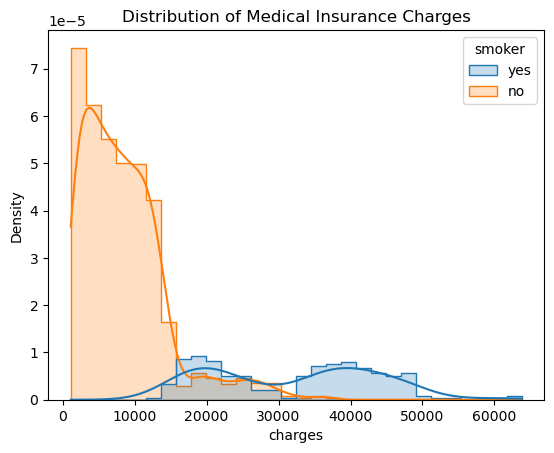

In [7]:
sns.histplot(
    data=df,
    x='charges',
    kde=True,
    hue='smoker',
    stat='density',
    element='step'
)
plt.title("Distribution of Medical Insurance Charges")

The target variable `charges` represents medical insurance costs.  
Its distribution is **right-skewed**, which violates the normality assumption of linear regression.

To stabilize variance and improve model performance, a **log transformation** of the target variable is applied.

In [8]:
df['log_charges'] = np.log(df['charges'])
df[['charges', 'log_charges']].head()

,charges,log_charges
0,16884.92400,9.734176
1,1725.55230,7.453302
2,4449.46200,8.400538
3,21984.47061,9.998092
4,3866.85520,8.260197


Text(0.5, 1.0, 'Log Charges Distribution')

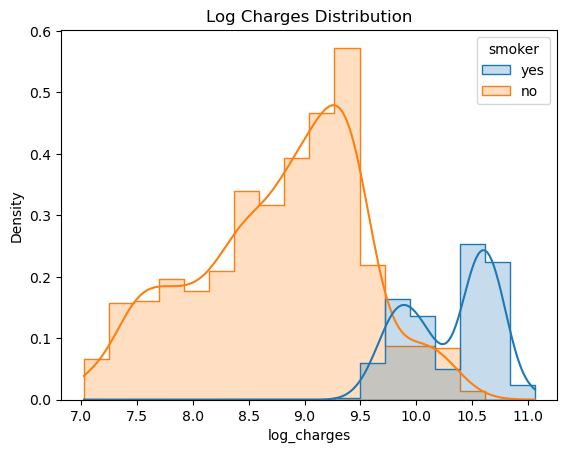

In [9]:
sns.histplot(
    data=df,
    x='log_charges',
    kde=True,
    stat='density',
    hue='smoker',
    element='step'
)
plt.title("Log Charges Distribution")

## 4) Features and Targets

In [10]:
# Features
X = df.drop(['charges', 'log_charges'], axis=1)

# Target
y = df['log_charges']

## 5) Categorical Feature Encoding

The dataset contains both numerical and categorical variables.  
Since machine learning models require numerical inputs, categorical variables must be encoded appropriately.

To avoid introducing artificial ordering and data leakage, categorical variables are encoded using **One-Hot Encoding** within a preprocessing pipeine.
.


### 5(a) Identifying Categorical & Numerical Columns

In [11]:
# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target variables from numerical list
numerical_cols.remove('charges')
numerical_cols.remove('log_charges')

In [12]:
print("Categorical Features : ",categorical_cols)
print("Numerical Features : ", numerical_cols)

Categorical Features :  ['sex', 'smoker', 'region']
Numerical Features :  ['age', 'bmi', 'children']


#### **Numerical & Categorical Features and Target**
- Numerical features : `['age', 'bmi', 'children']`
- Categorical Features : `['sex', 'smoker', 'region']`
- Target : `['log_charges']`

### 5(b) Column Transformer (Only Encoding)

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

preprocessor_dt = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

## 6) Pipeline with Decision Tree Regression

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

dt_model = Pipeline(steps=[
    ('preprocessing', preprocessor_dt),
    ('regressor', DecisionTreeRegressor(
        max_depth=5,
        min_samples_leaf=20,
        random_state=42
    ))
])

## 7) Train-Test-Split

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 8) Model Training

In [16]:
dt_model.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 9) Model Evalutation

In [17]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

train_pred = dt_model.predict(X_train)
test_pred  = dt_model.predict(X_test)

print(f"Train R2 Score: {r2_score(y_train, train_pred):.4f}")
print(f"Test  R2 Score: {r2_score(y_test, test_pred):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_pred)):.4f}")


Train R2 Score: 0.8395
Test  R2 Score: 0.8500
Test RMSE: 0.3672


## Model Evaluation and Overfitting Check

Decision Trees often show very high training performance but lower test performance.
The gap between train and test metrics is monitored to detect overfitting.

## 10) Hyperparameter Tuning

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'regressor__max_depth': [3, 5, 7, 10],
    'regressor__min_samples_leaf': [5, 10, 20, 50]
}

dt_gs = GridSearchCV(
    dt_model,
    param_grid,
    cv=5,
    scoring='r2'
)

dt_gs.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'regressor__max_depth': [3, 5, ...], 'regressor__min_samples_leaf': [5, 10, ...]}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...)]"


In [19]:
best_dt = dt_gs.best_estimator_
best_dt

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 11) Training vs Validation Error

This plot shows how model complexity affects performance.
Training error typically decreases with increasing complexity, while validation error may increase after a point due to overfittig.


In [20]:
from sklearn.model_selection import cross_val_score

max_depths = range(1, 16)

train_rmse = []
val_rmse = []

for depth in max_depths:
    
    dt_model = Pipeline(steps=[
        ('preprocessing', preprocessor_dt),
        ('regressor', DecisionTreeRegressor(
            max_depth=depth,
            min_samples_leaf=20,
            random_state=42
        ))
    ])
    
    # Training error
    dt_model.fit(X_train, y_train)
    train_pred = dt_model.predict(X_train)
    train_rmse.append(
        np.sqrt(mean_squared_error(y_train, train_pred))
    )
    
    # Validation error (cross-validation)
    cv_rmse = -cross_val_score(
        dt_model,
        X_train,
        y_train,
        cv=5,
        scoring='neg_root_mean_squared_error'
    ).mean()
    
    val_rmse.append(cv_rmse)

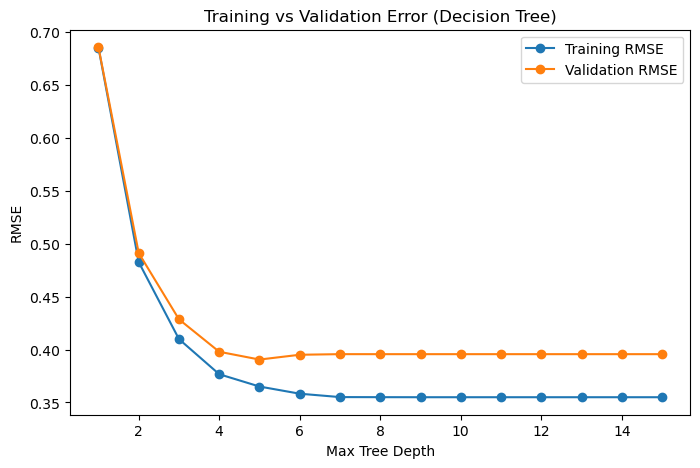

In [21]:
plt.figure(figsize=(8, 5))

plt.plot(max_depths, train_rmse, marker='o', label='Training RMSE')
plt.plot(max_depths, val_rmse, marker='o', label='Validation RMSE')

plt.xlabel('Max Tree Depth')
plt.ylabel('RMSE')
plt.title('Training vs Validation Error (Decision Tree)')
plt.legend()
plt.show()